In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
from src.resnet.utils.import_csv import import_csv, split_data


data = import_csv()
train_data, val_data = split_data(data=data)

In [3]:
len(train_data)

860

In [4]:
from src.resnet.dataloader.mygo_dataloader import dataset_transform, data_loader
train_data_transformed = dataset_transform(data=train_data, mode="train")
val_data_transformed = dataset_transform(data=val_data, mode="val")
train_loader = data_loader(tranformed_dataset=train_data_transformed, batch_size=16, num_workers=1, shuffle=True)
val_loader = data_loader(tranformed_dataset=val_data_transformed, batch_size=16, num_workers=1, shuffle=True)

In [5]:
len(train_loader)



54

In [6]:
len(val_loader)

14

16 16
torch.Size([16, 3, 224, 224])


Text(0.5, 1.0, '8')

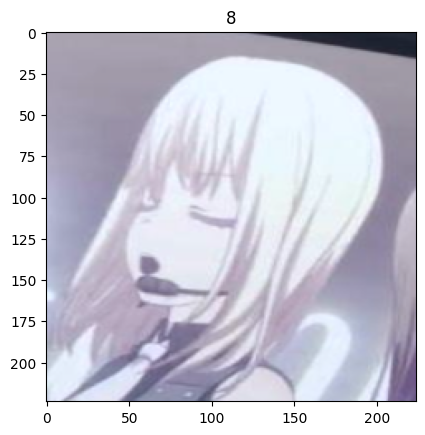

In [7]:
import matplotlib.pyplot as plt
import numpy as np
idx = 8
data, labels = next(iter(val_loader))
print(len(labels), len(data))
print(data.shape)
image_np = data[idx].numpy().transpose((1,2,0))
image_np = image_np * 0.229 + 0.485  # Undo normalization (normalize values back to the original range)

# If the image looks too dark due to normalization, try scaling it
image_np = np.clip(image_np, 0, 1) 

plt.imshow(image_np)
plt.title(labels[idx])

In [8]:
labels

('2',
 '2',
 '0',
 '3',
 '0',
 '6',
 '6',
 '8',
 '8',
 '2',
 '6',
 '2',
 '7',
 '5',
 '6',
 '7')

In [9]:
type(data)

torch.Tensor

In [15]:
from src.resnet.resnet_model.mygo_model import ResNet50
import torch.nn as nn
import torch

torch.manual_seed(69)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = ResNet50(input_channel=3).to(device)
from timeit import default_timer as timer

# Import tqdm for progress bar
from tqdm.auto import tqdm

def accuracy_fn(y_pred,y_true):
    # Get the predicted class by finding the index with the maximum value
    y_pred_class = torch.argmax(y_pred)
    
    # Check how many predictions are correct
    correct_predictions = torch.eq(y_pred_class, y_true).sum().item()
    
    # Calculate the accuracy
    accuracy = (correct_predictions / len(y_true)) * 100
    
    return accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_resnet.parameters(),
                            lr=0.01)

In [16]:
epochs = 10
all_labels = []
all_preds = []
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch = {epoch+1}\n-------------")
    train_loss = 0
    train_acc = 0
    model_resnet.train()
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)          
        y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
        optimizer.zero_grad()
        y_logits = model_resnet(X)
        # y_logits = y_logits - torch.max(y_logits).item()
        y_pred = torch.argmax(y_logits,dim=1)
        #calculate loss and costfunction
        acc = (y_pred == y).float().mean()
        loss = loss_fn(y_logits,y)
        train_loss += loss.item()
        train_acc += acc

        #grad to zero
        optimizer.zero_grad()

        #backpropagation
        loss.backward()

        #gradient descent
        optimizer.step()
        if(batch%20 == 0):
            print(f"loss: {loss.item():.5f} ,ACC: {acc:.2f}\n")
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc.item() /len(train_loader)

    #val dataset
    val_loss = 0
    val_acc = 0
    for batch, (X_val_batch, y_val) in enumerate(val_loader):
        X_val_batch = X_val_batch.to(device)
        y_val = torch.tensor([int(label) for label in y_val], dtype=torch.long, device=device)
        model_resnet.eval()
        with torch.inference_mode():
            y_val_logits = model_resnet(X_val_batch)
            # y_val_logits = y_val_logits - torch.max(y_val_logits).item()
            y_val_pred = torch.argmax(y_val_logits,dim=1)
            loss = loss_fn(y_val_logits,y_val)
            acc = (y_val_pred == y_val).float().mean()
            val_loss += loss.item()
            val_acc += acc
    val_loss /=len(val_loader)
    val_acc = val_acc.item() / len(val_loader)
    
    print(f"Train loss: {train_loss:.5f} ,Train acc: {train_acc:.2f}\n Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}\n")
time_end = timer()
duration = time_end-time_start
print(f"time use:{(duration):2f}seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch = 1
-------------
loss: 2.41494 ,ACC: 0.00

loss: 2.35582 ,ACC: 0.06

loss: 2.20688 ,ACC: 0.31

Train loss: 2.20674 ,Train acc: 0.23
 Val loss: 2.46410, Val acc: 0.22

Epoch = 2
-------------
loss: 2.33419 ,ACC: 0.06

loss: 1.96411 ,ACC: 0.38

loss: 2.28460 ,ACC: 0.25

Train loss: 1.98544 ,Train acc: 0.32
 Val loss: 2.87435, Val acc: 0.20

Epoch = 3
-------------
loss: 1.80876 ,ACC: 0.44

loss: 1.62833 ,ACC: 0.50

loss: 2.22909 ,ACC: 0.38

Train loss: 1.85497 ,Train acc: 0.35
 Val loss: 5.76030, Val acc: 0.19

Epoch = 4
-------------
loss: 1.68409 ,ACC: 0.44

loss: 1.51561 ,ACC: 0.50

loss: 1.68564 ,ACC: 0.44

Train loss: 1.68190 ,Train acc: 0.43
 Val loss: 1.98908, Val acc: 0.35

Epoch = 5
-------------
loss: 1.58644 ,ACC: 0.44

loss: 1.93738 ,ACC: 0.25

loss: 2.05358 ,ACC: 0.50

Train loss: 1.55973 ,Train acc: 0.47
 Val loss: 1.92291, Val acc: 0.36

Epoch = 6
-------------
loss: 1.32815 ,ACC: 0.44

loss: 1.23459 ,ACC: 0.62

loss: 1.74135 ,ACC: 0.44

Train loss: 1.45047 ,Train a

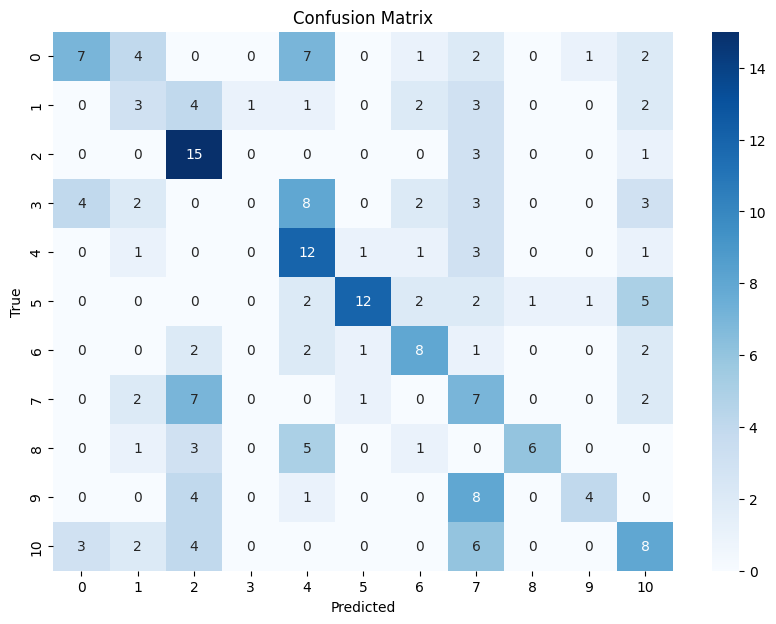

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lists to store all true labels and predictions
all_labels = []
all_preds = []

# Iterate over the batches
for batch, (X, y) in enumerate(val_loader):
    X = X.to(device)
    y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
    
    # Get predictions
    with torch.no_grad():
        y_pred = model_resnet(X).squeeze()
    # Convert predictions to class labels (e.g., using argmax for multi-class classification)
    y_pred_labels = torch.argmax(y_pred, dim=1)

    # Accumulate the true labels and predicted labels
    all_labels.extend(y.cpu().numpy())
    all_preds.extend(y_pred_labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [13]:
torch.save(model_resnet.state_dict(), "temp.pth")

In [14]:
model_resnet.state_dict()

OrderedDict([('conv_block_0.0.weight',
              tensor([[[[ 5.7192e-02,  5.1366e-02, -6.1288e-02,  ...,  2.8160e-02,
                         -1.4248e-02, -6.6873e-02],
                        [-4.1226e-02,  3.5109e-02,  2.1306e-02,  ..., -7.8455e-02,
                          6.2457e-02, -7.2572e-02],
                        [ 7.7664e-02, -8.0263e-02, -2.1544e-02,  ...,  2.4681e-02,
                         -8.0134e-02,  1.5705e-02],
                        ...,
                        [ 3.3523e-02,  2.1415e-02, -6.6377e-02,  ..., -2.3041e-02,
                          4.1661e-02, -2.2902e-02],
                        [ 7.5496e-03,  5.2528e-02, -7.2762e-02,  ..., -7.9230e-02,
                          1.4349e-02,  2.7047e-02],
                        [-7.9719e-02,  5.3203e-03,  6.7069e-02,  ...,  1.7715e-02,
                          2.4964e-03,  4.3944e-02]],
              
                       [[ 7.8499e-03, -1.9513e-02, -3.1467e-02,  ..., -1.9603e-02,
                       